In [1]:
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pylab as plt
from scipy import stats, integrate
import statsmodels
from sklearn.neighbors import KernelDensity

In [2]:
file_in=open('../data/aggregated_by_line_has_age_gender.csv','r')
excluded_chapters=['R','S','T','U','V','W','X','Y','Z']
comorbidity_preprocessing={};
age={};
i=0;
for line in file_in.readlines():
    sp=line.split(',')
    temp_list_=[];
    for code in range(1,len(sp[3:]),2):
        disease_=sp[3+code].replace(')','').replace('\n','').replace('\'','').strip();
        if disease_ not in temp_list_ and disease_[0] not in excluded_chapters:
            temp_list_.append(disease_);
    comorbidity_preprocessing[sp[0]]=temp_list_;
    age[sp[0]]=float(sp[2]);
        


In [3]:
#calculate age distribution
file_in=open('../data/aggregated_by_line_has_age_gender.csv','r')
ages_list=[];
i=0;
for line in file_in.readlines():
    sp=line.split(',')
    age_=float(sp[2]);
    ages_list.append([age_]);

age_estimator=KernelDensity(kernel='gaussian', bandwidth=1.5).fit(ages_list);
age_norm=np.exp(age_estimator.score_samples([[_] for _ in np.linspace(0,100,100)]))

In [4]:
#takes a long time
#write the results to 

diseases_idx={};
age_distrubutions=np.zeros([1569,100]);
kde={};
i=0;
for _1 in comorbidity_preprocessing:
    for _2 in comorbidity_preprocessing[_1]:
        if _2 not in diseases_idx.keys():
            diseases_idx[_2]=i;
            kde[_2]=[[float(age[_1])]];
            i+=1;
        if age[_1]<=99:            
            age_distrubutions[diseases_idx[_2],int(np.round(age[_1]))]+=1;
            kde[_2].append([float(age[_1])]);


In [5]:
#kernel density estimation
rv_diseases_idx={i:diseases_idx[i] for i in diseases_idx}
kde_age_distrubutions=np.zeros([1569,100]);
for i in kde:
    estimator=KernelDensity(kernel='gaussian', bandwidth=2).fit(np.array(kde[i]));
    kde_age_distrubutions[diseases_idx[i],:]=np.exp(estimator.score_samples([[_] for _ in np.linspace(0,100,100)]));
    kde_age_distrubutions[diseases_idx[i],:]=(kde_age_distrubutions[diseases_idx[i],:]/age_norm);
    kde_age_distrubutions[diseases_idx[i],:]=kde_age_distrubutions[diseases_idx[i],:]/kde_age_distrubutions[diseases_idx[i],:].sum()
    
    

In [6]:
#write age distribution to text file
diseases_idx_reverse={diseases_idx[i]:i for i in diseases_idx};
file_out=open('age_distributions.txt','w');
for i in range(age_distrubutions.shape[0]):
    line=str(diseases_idx_reverse[i]);
    for _1 in age_distrubutions[i,:]:
        line=line+','+str(_1);
    line=line+'\n';
    file_out.writelines(line);
file_out.flush();  

In [7]:
#write age distribution to text file
diseases_idx_reverse={diseases_idx[i]:i for i in diseases_idx};
file_out=open('kde_age_distributions.txt','w');
for i in range(kde_age_distrubutions.shape[0]):
    line=str(diseases_idx_reverse[i]);
    for _1 in kde_age_distrubutions[i,:]:
        line=line+','+str(_1);
    line=line+'\n';
    file_out.writelines(line);
file_out.flush();  

In [8]:
#write the sums of the counts
sums_=np.sum(age_distrubutions,1);
file_out=open('sums.txt','w');
for i in range(len(sums_)):
    file_out.writelines('{},{}\n'.format(diseases_idx_reverse[i],sums_[i]));
file_out.flush()
    

#clustering starts here

In [9]:
#reads the age counts
file_in=open('sums.txt','r');
sums=np.zeros([1569,1]);
_idx=0;
for i in file_in.readlines():
    sp=i.split(',')
    sums[_idx]=[float(i.strip('\n')) for i in sp[1:]]
    _idx+=1;

In [10]:
#reads the age counts
file_in=open('kde_age_distributions.txt','r');
kde_dict_age_distribution={};
dic_idx={};
rv_dic_idx={};
idx=0;

for i in file_in.readlines():
    sp=i.split(',');
    kde_dict_age_distribution[sp[0]]=[float(i.strip('\n')) for i in sp[1:]]
    dic_idx[sp[0]]=idx;
    rv_dic_idx[idx]=sp[0];
    idx+=1;
    
age_distrub=np.zeros([len(kde_dict_age_distribution.keys()),100]);
for i in dic_idx:
    age_distrub[dic_idx[i]]=kde_dict_age_distribution[i];


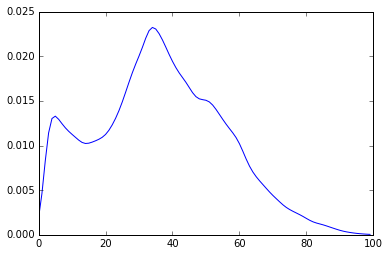

In [225]:
plt.plot(age_norm)

In [213]:
age_distrub_filtered.shape

(278, 100)

In [273]:
#filtering the age_distrib before clustering
cnt_thr=1500;
age_distrub_filtered=age_distrub[[_[0] for _ in sums>cnt_thr],:];
sums_filtered=sums[[_[0] for _ in sums>cnt_thr],:];
dic_idx_filtered={};
idx=0;
idx_2=0;
for i in sums>cnt_thr:
    if i==True:
        dic_idx_filtered[idx_2]=rv_dic_idx[idx];
        idx_2+=1;
    idx+=1;
rev_dic_idx_filtered={dic_idx_filtered[_]:_ for _ in dic_idx_filtered};

print 'the new shape is ',age_distrub_filtered.shape

the new shape is  (278, 100)


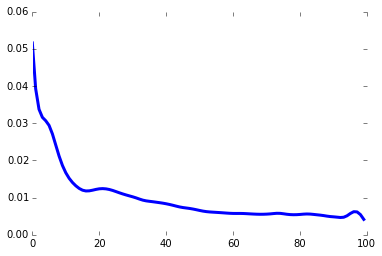

In [263]:
plt.plot(age_distrub_filtered[3])

In [274]:
#clustering now
# needed imports
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
import numpy as np

In [275]:
# generate the linkage matrix
Z = linkage(age_distrub_filtered, method='ward',metric='euclidean')

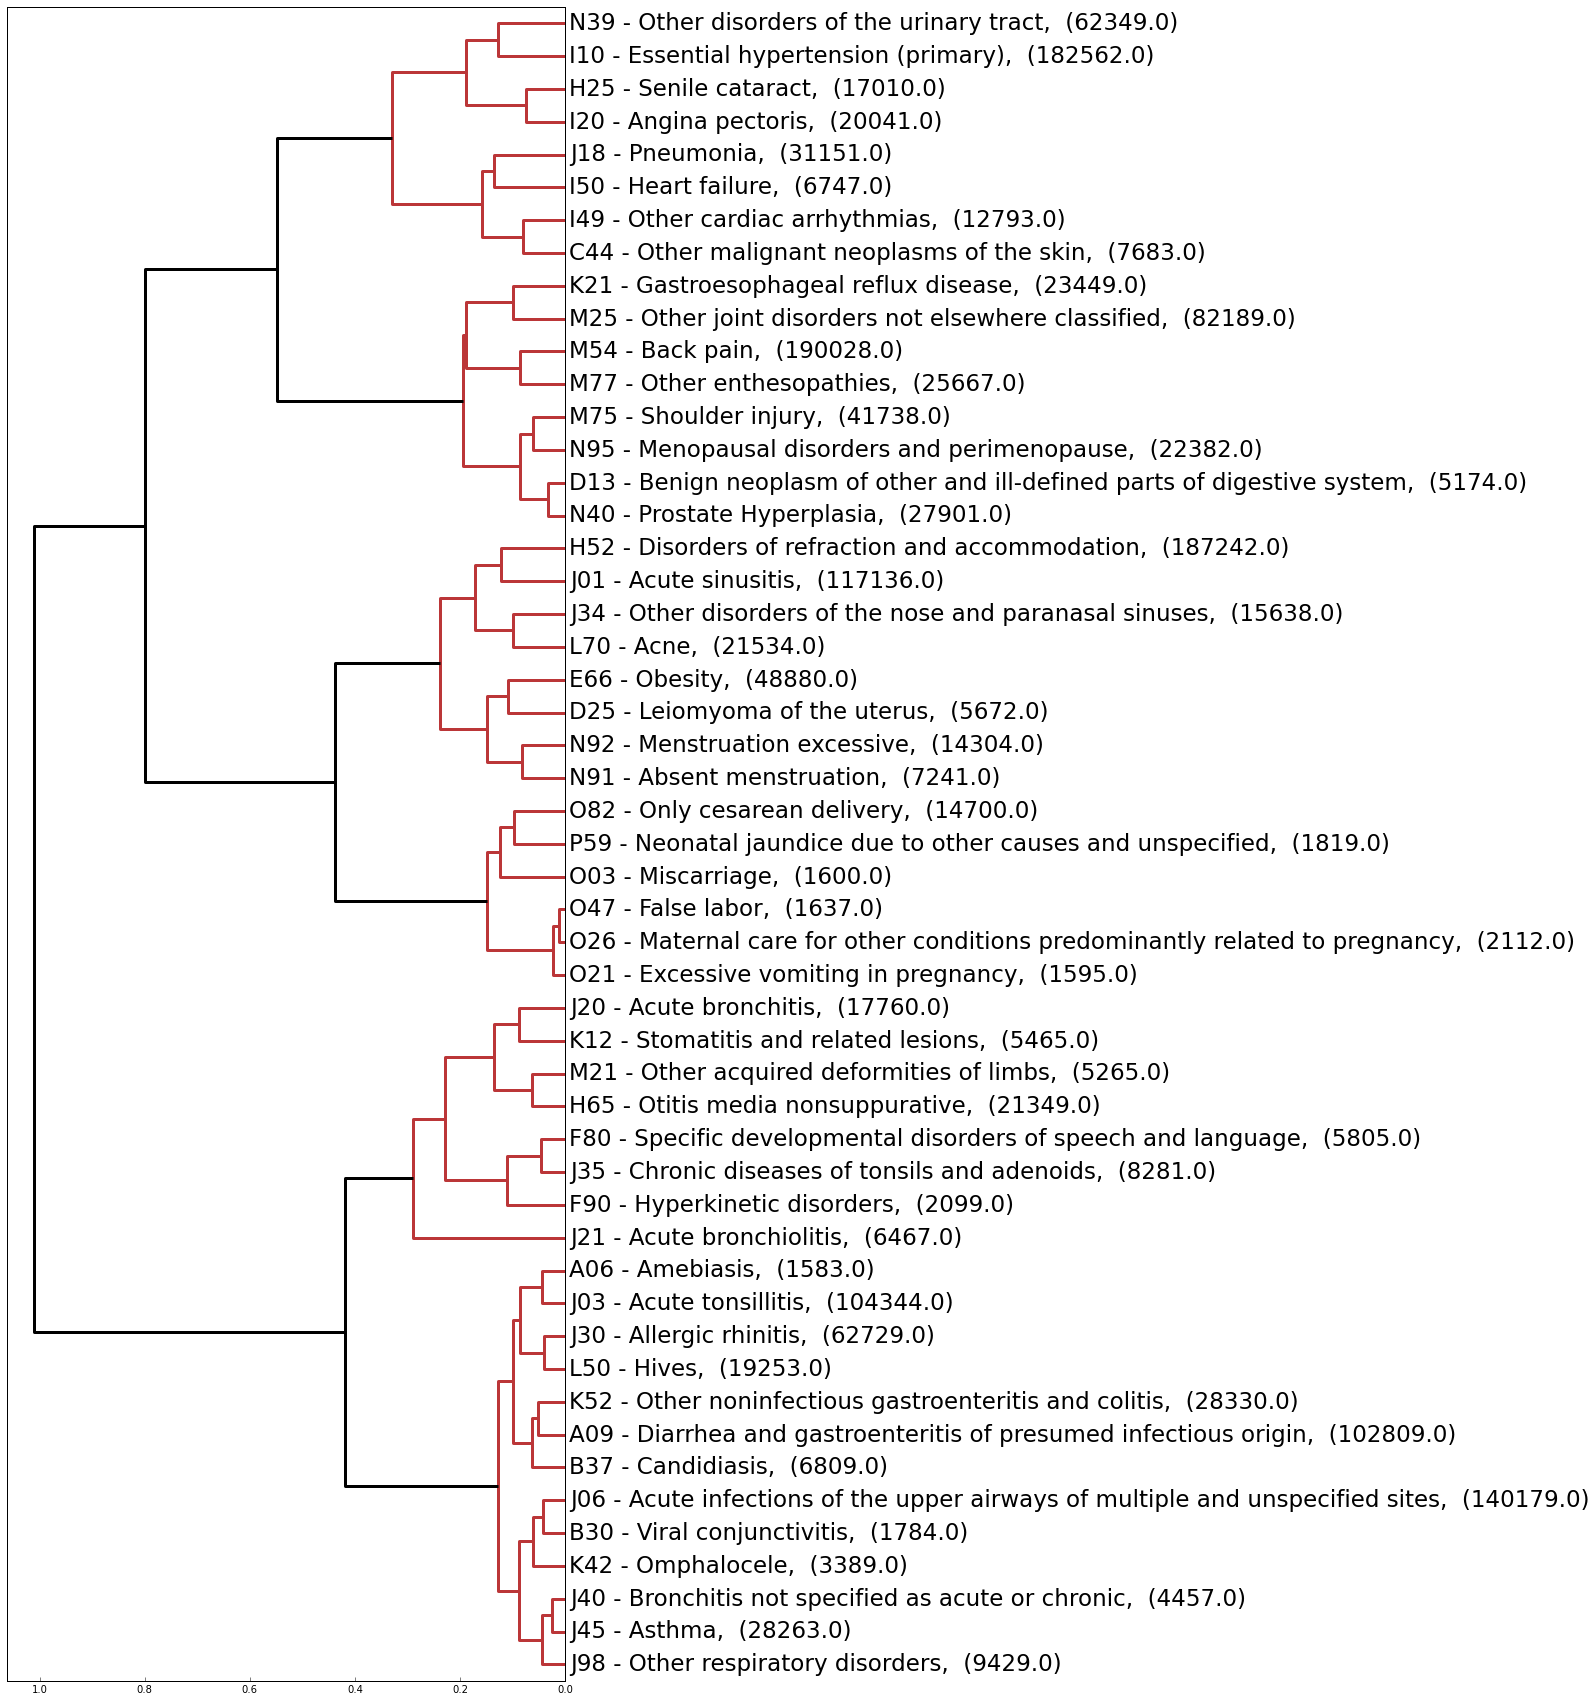

In [276]:
fig=plt.figure(figsize=(10,30))
ax = fig.add_subplot(111)
ax.xaxis.tick_bottom();
label_list=[dic_idx_filtered[i] for i in dic_idx_filtered];
color = ["k"]*(2*1000-1)
for i in range(0,550):
    color[i]='#bb3638'
plt.rc('axes',edgecolor='w')
plt.rcParams['lines.linewidth'] = 3
a=dendrogram(Z,orientation='left',leaf_label_func=leaf_label,leaf_font_size=23,color_threshold=0.4,p=5,truncate_mode='level',link_color_func=lambda x: color[x])  # font size for the x axis labels
plt.savefig('dendogram.pdf', bbox_inches='tight')

clusters=fcluster(Z,6,criterion='maxclust')

In [277]:
#read code discreptions
detailed_name={};
file_in=open('../data/CID-10cats_.csv','r');
print file_in.readline();
for i in file_in.readlines():
    sp=i.split(',');
    detailed_name[sp[0]]=sp[3].replace('"','');

CAT,to_group,CLASSIF,DESCRIPTION,DESCRABREV,DESCRABREV,REFER,DESCRICAO,EXCLUIDOS



In [278]:
 
    

def leaf_label(id):
    id=int(id);
    n=len(label_list);
    if id<n:
        return str(label_list[id]) +' - '+ detailed_name[label_list[id]]+ ',  (' + str(sums_filtered[id][0]) + ')';
    
    else:
        a=leaf_label(Z[id-n,0]); 
        b=leaf_label(Z[id-n,1]); 
        if float(a.split(',')[1].replace('(','').replace(')',''))>float(b.split(',')[1].replace('(','').replace(')','')):
            return a
        else:
            return b



    

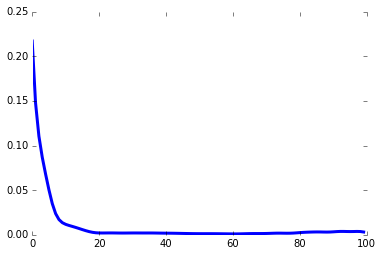

In [279]:
plt.plot(age_distrub[diseases_idx['J21']])

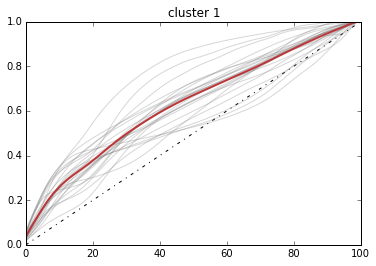

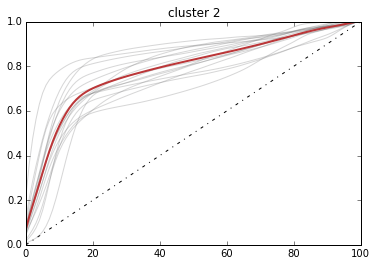

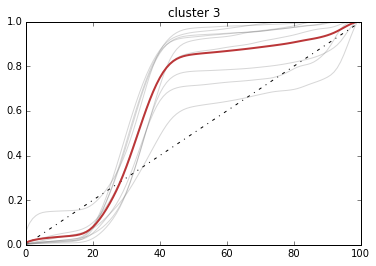

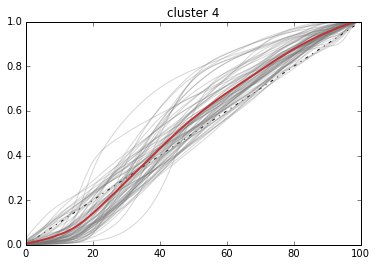

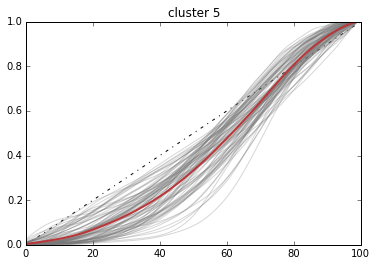

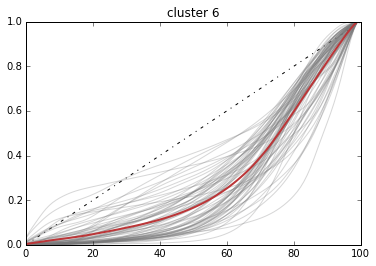

In [286]:
for i in set(clusters):
    plt.figure()
    plt.rc('axes',edgecolor='k')
    avg=[];
    plt.plot(np.linspace(0,100,50),np.linspace(0,1,50),'k-.',linewidth=1)
    for j in age_distrub_filtered[clusters==i,:]:
        plt.hold(True)
        plt.ylim([0,1])
        plt.plot(np.cumsum(j),'#79797a',alpha=0.3,linewidth=1);
        avg.append(np.cumsum(j))
    plt.plot(np.mean(avg,0),'#bb3638',linewidth=2)
    plt.title('cluster {}'.format(i))
    


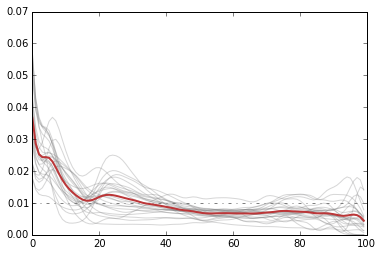

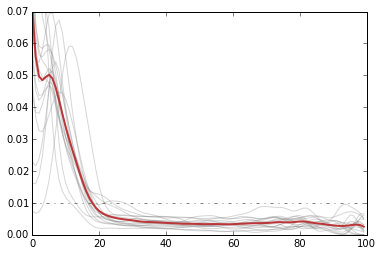

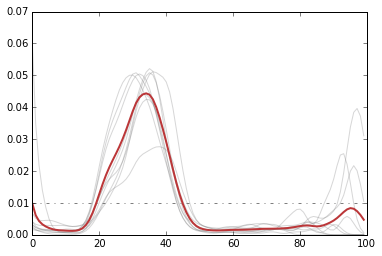

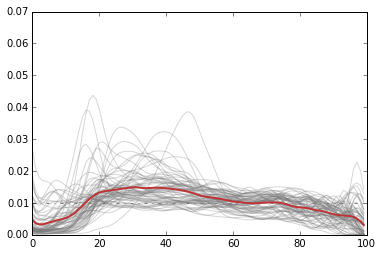

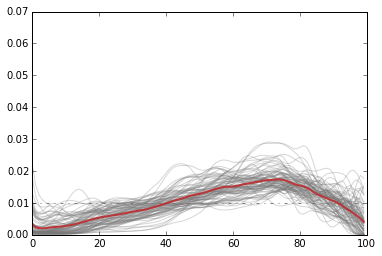

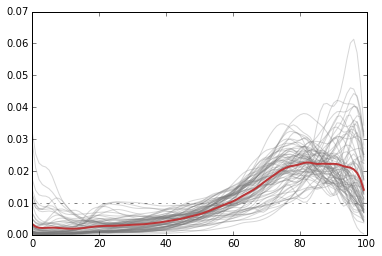

In [287]:
for i in set(clusters):
    plt.figure()
    plt.rc('axes',edgecolor='k')
    avg=[];
    plt.plot(np.linspace(0,100,50),np.ones(50)*0.01,'k-.',linewidth=0.5)
    for j in age_distrub_filtered[clusters==i,:]:
        plt.hold(True)
        plt.ylim([0,0.07])
        plt.plot(j,'#79797a',alpha=0.3,linewidth=1);
        avg.append(j)
    plt.plot(np.mean(avg,0),'#bb3638',linewidth=2)


In [252]:
#finally write cluster assignments
file_out=open('cluster_assignments.csv','w')
for i in range(len(clusters)):
    file_out.writelines('{},{}\n'.format(dic_idx_filtered[i],clusters[i]))
file_out.flush()

In [253]:
len(clusters)

345